In [6]:
!pip install dtaidistance

In [7]:
# ✅ [1] 필수 패키지 임포트
import os
import pandas as pd
import numpy as np
import random
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from scipy.stats import wasserstein_distance, energy_distance
from scipy.spatial import distance
from sklearn import metrics

from dtaidistance import dtw  # pip install dtaidistance
from tqdm import tqdm
import torch

In [8]:
def dummy_creation(dataset, dummy_categories):
    for i in dummy_categories:
        dataset_dummy = pd.get_dummies(dataset[i])

        dataset=pd.concat([dataset,dataset_dummy],
                          axis=1)
        dataset=dataset.drop(i,axis=1)
    return dataset

## 1. 데이터 불러오기 (Load a Dataset)

Data Source: https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill

In [9]:
## google drive 연결. (*Local에서 실행 시 생략)
from google.colab import drive
drive.mount('/content/drive')

# 데이터셋이 저장된 Google Drive 내 폴더 경로 지정
FOLDER_DIR = "drive/MyDrive/Side Projects/2505 - 한양대 특강/dataset-SMART"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 개별 실험 데이터를 저장할 리스트 초기화
experiments = []

# 폴더 내 파일들을 순회
for file_name in os.listdir(FOLDER_DIR):
  if file_name.startswith("experiment"):
    df = pd.DataFrame()  # 빈 데이터프레임 생성 (선택사항)

    df = pd.read_csv(f"{FOLDER_DIR}/{file_name}", index_col=None, header=0)

    # 파일명에서 실험 번호 추출하여 'Experiment' 컬럼에 추가 (예: experiment02.csv → 2)
    df['Experiment'] = int(file_name[-6:-4])
    experiments.append(df)

# 개별 실험 데이터를 하나의 데이터프레임으로 병합
df_raw_original = pd.concat(experiments, axis=0, ignore_index=True)

In [11]:
# 메타데이터 CSV 파일 읽기 (조건 정보 포함)
df_meta = pd.read_csv(os.path.join(FOLDER_DIR, "train.csv"))

# tool_condition, clamp_pressure, feedrate 순으로 정렬
df_meta = df_meta.sort_values(by=['tool_condition', 'clamp_pressure', 'feedrate'])

# tool_condition이 'worn'이면 1, 아니면 0으로 라벨링
df_meta['label'] = df_meta['tool_condition'].apply(lambda x: 1 if x == "worn" else 0)

# feedrate와 clamp_pressure를 조합해 WorkingCondition이라는 새로운 컬럼 생성
df_meta['WorkingCondition'] = df_meta['feedrate'].apply(lambda x: str(x)) + "-" + df_meta['clamp_pressure'].apply(lambda x: str(x))


In [12]:
df_raw = dummy_creation(df_raw_original, ['Machining_Process'])

df_raw['label'] = 0
df_raw['label'] = df_raw['Experiment'].apply(lambda x: df_meta[df_meta['No'] == x]['label'].values[0])

no_wc_dict = dict(zip(df_meta['No'], df_meta['WorkingCondition']))

df_raw['WorkingCondition'] = df_raw['Experiment'].apply(lambda x: no_wc_dict[x])

## 2. 데이터 전처리

### 2-1. 센서 데이터만

In [35]:
col_sensor = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage',
       'S1_OutputPower', 'S1_SystemInertia']

col_bn = ['X1_ActualPosition', 'X1_ActualVelocity', 'X1_ActualAcceleration',
       'X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration',
       'X1_CurrentFeedback', 'X1_DCBusVoltage', 'X1_OutputCurrent',
       'X1_OutputVoltage', 'X1_OutputPower', 'Y1_ActualPosition',
       'Y1_ActualVelocity', 'Y1_ActualAcceleration', 'Y1_CommandPosition',
       'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Y1_CurrentFeedback',
       'Y1_DCBusVoltage', 'Y1_OutputCurrent', 'Y1_OutputVoltage',
       'Y1_OutputPower', 'Z1_ActualPosition', 'Z1_ActualVelocity',
       'Z1_ActualAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
       'Z1_CommandAcceleration', 'Z1_CurrentFeedback', 'Z1_DCBusVoltage',
       'Z1_OutputCurrent', 'Z1_OutputVoltage', 'S1_ActualPosition',
       'S1_ActualVelocity', 'S1_ActualAcceleration', 'S1_CommandPosition',
       'S1_CommandVelocity', 'S1_CommandAcceleration', 'S1_CurrentFeedback',
       'S1_DCBusVoltage', 'S1_OutputCurrent', 'S1_OutputVoltage',
       'S1_OutputPower', 'S1_SystemInertia','feedrate','clamp_pressure','layer']

col_CNCCode = ['M1_CURRENT_PROGRAM_NUMBER',
       'M1_sequence_number', 'M1_CURRENT_FEEDRATE', 'Experiment', 'End',
       'Layer 1 Down', 'Layer 1 Up', 'Layer 2 Down', 'Layer 2 Up',
       'Layer 3 Down', 'Layer 3 Up', 'Prep', 'Repositioning', 'Starting',
       'end', 'label']

### 2-2. 공구 마모와 유관한 구간만 필터링

In [36]:
# 절삭 구간만 자르기 -> 공구 마모와 관련된 구간
layer_cols = ['Layer 1 Down', 'Layer 1 Up', 'Layer 2 Down', 'Layer 2 Up', 'Layer 3 Down', 'Layer 3 Up']
df_raw['Layer_Total'] = df_raw[layer_cols].sum(axis=1)  # axis=1로 행 방향 합계
df_layer = df_raw[df_raw['Layer_Total'] > 0].copy() # .copy()를 사용하여 복사본 생성

# Layer to Working Conditions
df_layer.loc[:, 'Layer1'] = df_layer[['Layer 1 Down', 'Layer 1 Up']].sum(axis=1)
df_layer.loc[:, 'Layer2'] = df_layer[['Layer 2 Down', 'Layer 2 Up']].sum(axis=1)
df_layer.loc[:, 'Layer3'] = df_layer[['Layer 3 Down', 'Layer 3 Up']].sum(axis=1)

df_layer.loc[:, 'Layer_Info'] = df_layer[['Layer1', 'Layer2', 'Layer3']].idxmax(axis=1)  # idxmax로 최대값 컬럼명 가져오기
df_layer.loc[:, 'Layer_Info'] = df_layer['Layer_Info'].map({'Layer1': 1, 'Layer2': 2, 'Layer3': 3})  # 컬럼명을 숫자로 매핑

# Scenario = Experiment (Load X Speed X Label) X Layer
df_layer.loc[:, 'SCN'] = df_layer['Experiment'].astype(str) + "-" + df_layer['Layer_Info'].astype(str)  # 문자열로 변환하여 결합

## 3. 데이터 시각화 (Data Visualization)

### 3-0. 절삭 구간

<ipython-input-14-ab2317febe97>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_process['Process_Numeric'] = df_process['Machining_Process'].map(process_mapping)


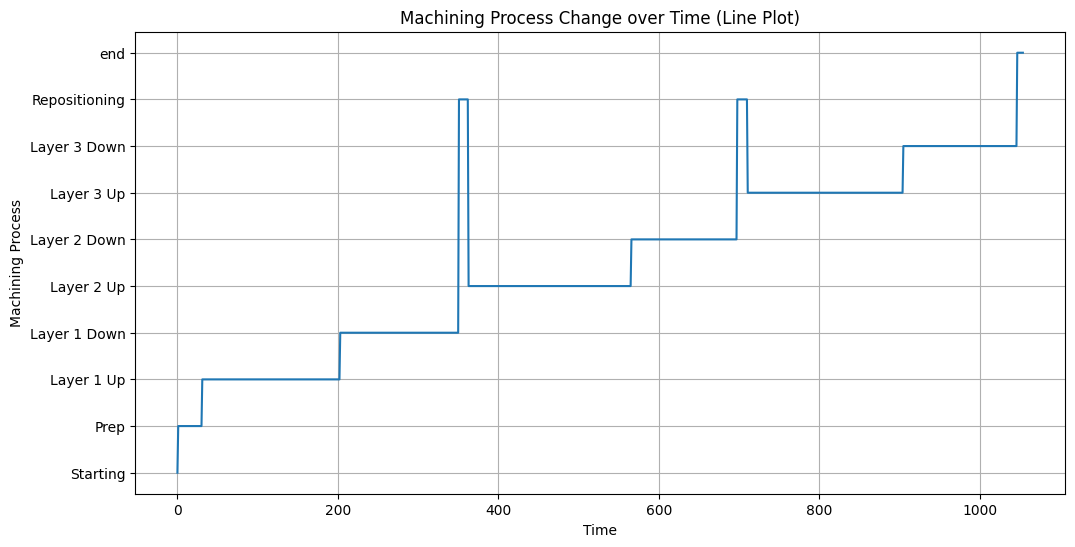

In [14]:
# 데이터프레임에서 필요한 컬럼만 선택
df_process = df_raw_original[df_raw_original["Experiment"] == 1]

# Machining_Process 컬럼을 숫자로 변환 (Scatter plot에 필요)
process_mapping = {
    'Layer 1 Up': 2,
    'Layer 1 Down': 3,
    'Layer 2 Up': 4,
    'Layer 2 Down': 5,
    'Layer 3 Up': 6,
    'Layer 3 Down': 7,
    'Repositioning': 8,
    'Prep': 1,
    'Starting': 0,
    'end': 9
}
df_process['Process_Numeric'] = df_process['Machining_Process'].map(process_mapping)

plt.figure(figsize=(12, 6))
plt.plot(df_process['Process_Numeric'])
plt.title('Machining Process Change over Time (Line Plot)')
plt.xlabel('Time')
plt.ylabel('Machining Process')
plt.yticks(list(process_mapping.values()), list(process_mapping.keys()))
plt.grid(True)
plt.show()

### 3-1. Working Condition별 데이터 Row 수

<ipython-input-51-d6a3c938b571>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=condition_counts, x='WorkingCondition', y='Count', palette='pastel')


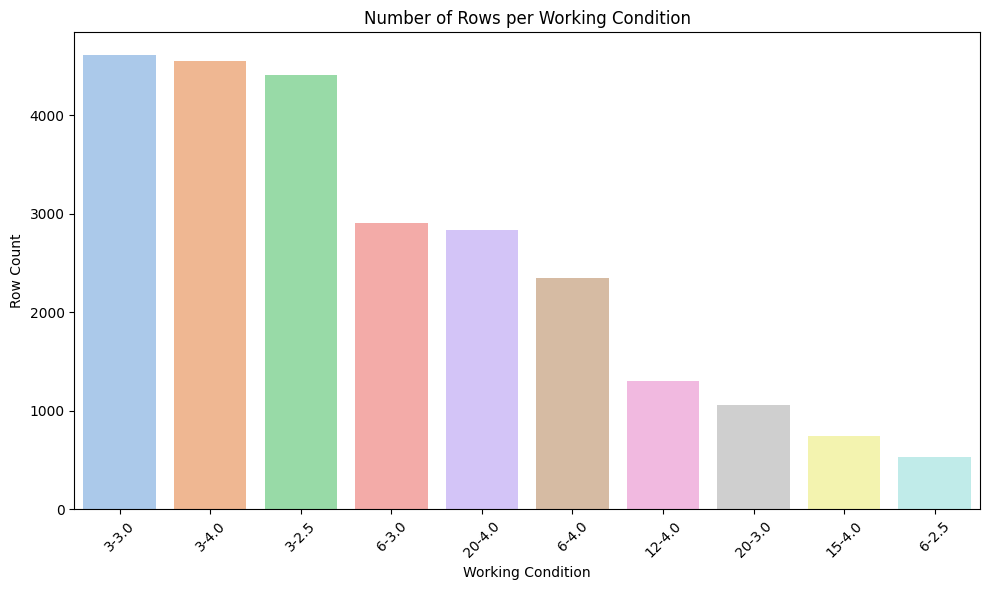

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

condition_counts = df_raw['WorkingCondition'].value_counts().reset_index()
condition_counts.columns = ['WorkingCondition', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=condition_counts, x='WorkingCondition', y='Count', palette='pastel')
plt.title('Number of Rows per Working Condition')
plt.xlabel('Working Condition')
plt.ylabel('Row Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3-2. 여러 센서의 평균값을 WorkingCondition별로 비교 (히트맵)

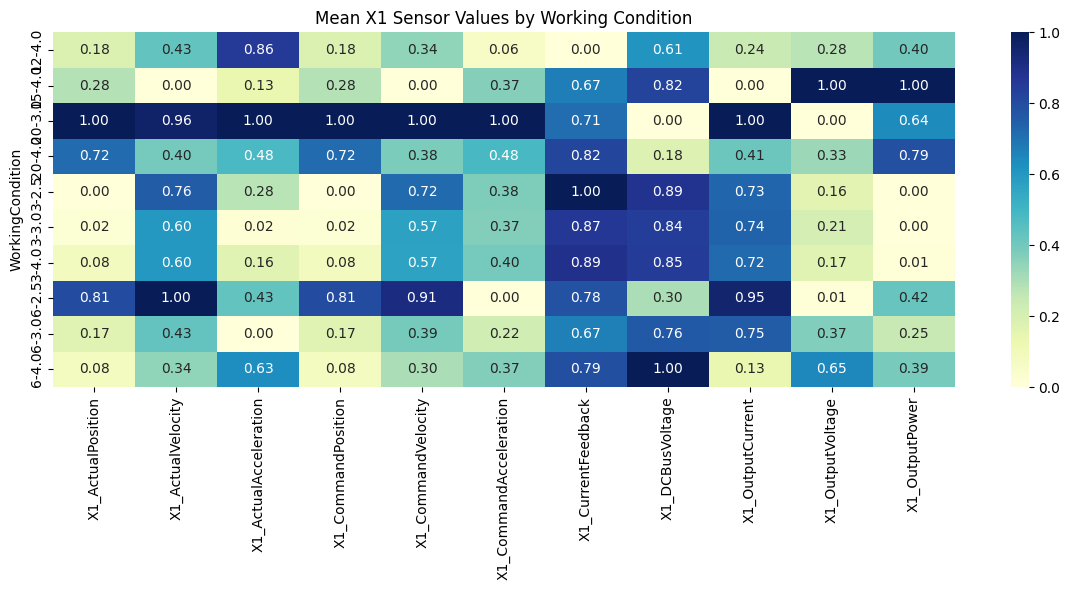

In [52]:
sensor_cols = [col for col in df_raw.columns if col.startswith('X1_')]

# 평균값 집계
sensor_means = df_raw.groupby('WorkingCondition')[sensor_cols].mean()

# 정규화 (각 센서 컬럼별로 0~1 범위로)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sensor_means_scaled = pd.DataFrame(
    scaler.fit_transform(sensor_means),
    index=sensor_means.index,
    columns=sensor_means.columns
)

# 히트맵
plt.figure(figsize=(12, 6))
sns.heatmap(sensor_means_scaled, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Mean X1 Sensor Values by Working Condition')
plt.tight_layout()
plt.show()

### 3-3. Working Condition 별 분포 비교 (t-sne 시각화)

In [41]:
import random
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Sensor Data
y = df_layer['label']
list_scn = df_layer['SCN']
df_feature = df_layer[col_sensor].copy(deep = True)

# Standard Scale
standard_scaler = StandardScaler()
df_scaled = pd.DataFrame(standard_scaler.fit_transform(df_feature),columns=df_feature.columns)

df_scaled['SCN'] = list_scn.values
df_scaled['Experiment'] = df_layer['Experiment'].values

choice = random.sample(range(0,len(df_scaled)),8000)

In [ ]:
df_tsne = df_scaled.iloc[choice]
tsne_np = TSNE(n_components = 2).fit_transform(df_tsne[col_sensor])
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

# class target 정보 불러오기
tsne_df['target'] = df_tsne['Experiment'].apply(lambda x: str(df_meta[df_meta["No"] == x]['WorkingCondition'].values[0])).values
tsne_df['label']  = df_tsne['Experiment'].apply(lambda x: str(df_meta[df_meta["No"] == x]['label'].values[0])).values
tsne_df['TMP']    = tsne_df['label']+tsne_df['target']

6-3.0 15-4.0


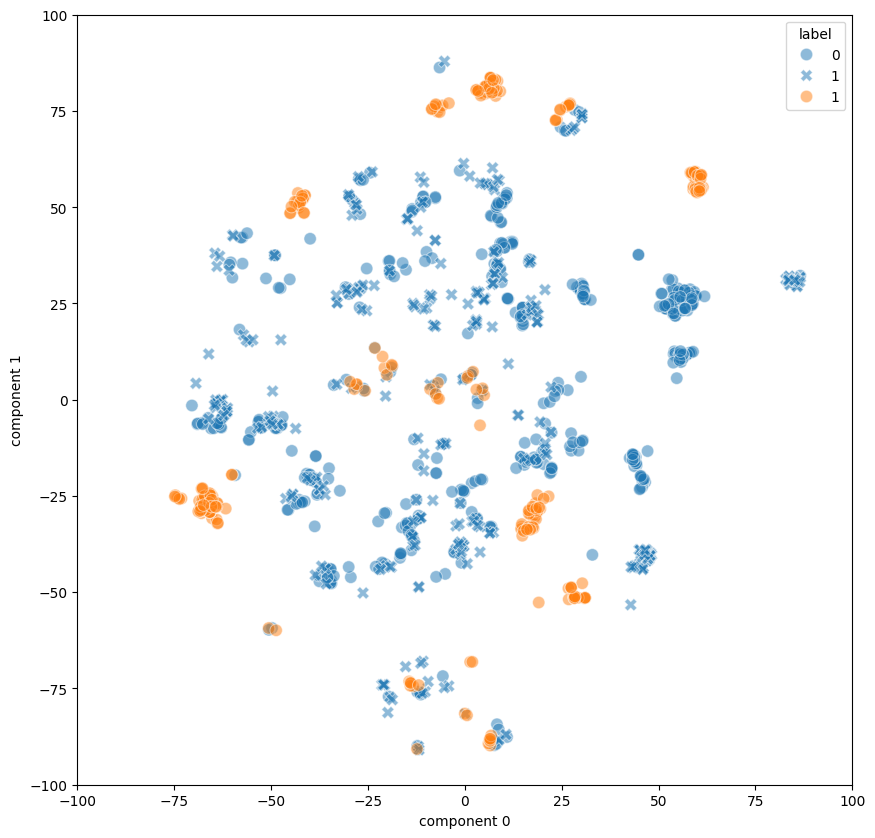

In [16]:
list_df = []
# target 별 분리
for idx in tsne_df['target'].unique():
    list_df.append(tsne_df[tsne_df['target'] == idx])

print(tsne_df['target'].unique()[6], tsne_df['target'].unique()[8])

plt.figure(figsize=(10,10))
# target 별 시각화
for idx in [6,8]:
    df_plot = list_df[idx]
    df_plot=df_plot.sort_values(by = 'label')
    sns.scatterplot(x=df_plot['component 0'],y=df_plot['component 1'], style=df_plot['label'], s = 80, alpha = 0.5)

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

## 4. 고장 진단 모델 개발 – 이상적인 환경 가정

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

In [38]:
# 1. 스케일링 (표준화)

# Sensor Data
y = df_layer['label']
list_scn = df_layer['SCN']
df_feature = df_layer[col_sensor].copy(deep = True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feature)

# 2. Random Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. 예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# 5. 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 6. 출력
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(report)

Accuracy : 0.99
Precision: 0.99
Recall   : 0.99
F1 Score : 0.99

Confusion Matrix:
[[1559   27]
 [  13 1905]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1586
           1       0.99      0.99      0.99      1918

    accuracy                           0.99      3504
   macro avg       0.99      0.99      0.99      3504
weighted avg       0.99      0.99      0.99      3504



## 5. 현실 제약 조건을 고려한 고장 진단 모델 개발

### 5-1. 라벨이 없는 경우 (Unlabeled Data)

In [57]:
# 실험 설계
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# 2. Isolation Forest 모델 정의 및 학습
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(X_train)

# 3. 예측 수행
### 1: 이상치, 0: 정상치
y_pred = model.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in y_pred]

# 4. 이상치 점수 (anomaly score)
scores = model.decision_function(X_test)

# 5. 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 6. 출력
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(report)

Accuracy : 0.50
Precision: 0.61
Recall   : 0.54
F1 Score : 0.43

Confusion Matrix:
[[1499   87]
 [1655  263]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.95      0.63      1586
           1       0.75      0.14      0.23      1918

    accuracy                           0.50      3504
   macro avg       0.61      0.54      0.43      3504
weighted avg       0.63      0.50      0.41      3504



### 5-2. 정상 데이터만 존재하는 경우 (One-Class Scenario)

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# 1. 데이터 분리
df_normal = df_layer[df_layer['label'] == 0].copy(deep=True)
df_abnormal = df_layer[df_layer['label'] == 1].copy(deep=True)

# 2. Normal 데이터 스케일링
X_normal = df_normal[col_sensor].copy(deep=True)
y_normal = df_normal['label']

scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# 3. Normal 데이터에서 Train/Test 분리
X_train, X_test_normal, y_train, y_test_normal = train_test_split(
    X_normal_scaled, y_normal, test_size=0.2, random_state=42
)

# 4. Abnormal 데이터 20% 샘플링 후 transform
df_abnormal_sampled = df_abnormal.sample(frac=0.2, random_state=42)
X_abnormal_scaled = scaler.transform(df_abnormal_sampled[col_sensor].copy(deep=True))
y_abnormal = df_abnormal_sampled['label']

# 5. 테스트 데이터 합치기
X_test = np.concatenate([X_test_normal, X_abnormal_scaled], axis=0)
y_test = np.concatenate([y_test_normal, y_abnormal], axis=0)

In [59]:
# 2. Isolation Forest 모델 정의 및 학습
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(X_train)

# 3. 예측 수행
### 1: 이상치, 0: 정상치
y_pred = model.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in y_pred]

# 4. 이상치 점수 (anomaly score)
scores = model.decision_function(X_test)

# 5. 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 6. 출력
print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(report)

Accuracy : 0.53
Precision: 0.61
Recall   : 0.56
F1 Score : 0.49

Confusion Matrix:
[[1446  163]
 [1467  429]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.90      0.64      1609
           1       0.72      0.23      0.34      1896

    accuracy                           0.53      3505
   macro avg       0.61      0.56      0.49      3505
weighted avg       0.62      0.53      0.48      3505



### 5-3. 새로운 Working Condition의 등장

In [76]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# 컬럼 정의 (필요 시 수정)
col_sensor = col_sensor
label_col = 'label'
condition_col = 'WorkingCondition'  # 예시 컬럼 이름

# 1. working condition 중 하나 임의로 선택
unique_conditions = df_layer[condition_col].unique()
np.random.seed(42)
test_condition = np.random.choice(unique_conditions)
test_condition = '20-3.0' ## (['6-4.0', '20-3.0', '6-3.0', '20-4.0', '3-2.5', '3-4.0', '3-3.0']

print(f"✅ Unseen working condition: {test_condition}")

# 2. 테스트 세트와 학습 세트 나누기
df_test = df_layer[df_layer[condition_col] == test_condition].copy()
df_train_partial = df_layer[df_layer[condition_col] != test_condition].copy()
df_train_full = df_layer.copy()

# 3. 피처 및 레이블 분리
X_test_raw = df_test[col_sensor]
y_test = df_test[label_col]
X_partial_raw = df_train_partial[col_sensor]
y_partial = df_train_partial[label_col]
X_full_raw = df_train_full[col_sensor]
y_full = df_train_full[label_col]

# 4. 스케일링 (fit은 train set 기준)
scaler_partial = StandardScaler()
X_partial = scaler_partial.fit_transform(X_partial_raw)
X_test_partial = scaler_partial.transform(X_test_raw)

scaler_full = StandardScaler()
X_full = scaler_full.fit_transform(X_full_raw)
X_test_full = scaler_full.transform(X_test_raw)

# 5. 모델 학습 및 예측
model_partial = RandomForestClassifier(n_estimators=100, random_state=42)
model_partial.fit(X_partial, y_partial)
y_pred_partial = model_partial.predict(X_test_partial)

model_full = RandomForestClassifier(n_estimators=100, random_state=42)
model_full.fit(X_full, y_full)
y_pred_full = model_full.predict(X_test_full)

# 6. F1-score 비교
f1_partial = f1_score(y_test, y_pred_partial, average='macro')
f1_full = f1_score(y_test, y_pred_full, average='macro')

# 7. 출력
print(f"\n📈 F1-score (ideal scenario): {f1_full:.4f}")
print(f"📉 F1-score (unseen scenario): {f1_partial:.4f}")

✅ Unseen working condition: 20-3.0

📈 F1-score (ideal scenario): 1.0000
📉 F1-score (unseen scenario): 0.3157


## 6. 현실 제약 조건에 대한 대응 전략

### 6-1. 운영조간 간 Similarity 산출

In [64]:
# 모든 WC 간의 조합
cand = df_scaled['Experiment'].unique()

wc_tot = []
for num in range(1, len(cand)):
    for i in itertools.combinations(cand,num):
        wc_tot.append(i)

wc_tot_comb = []
for idx in range(0,len(wc_tot)):
    src_wc = wc_tot[idx]
    for idx2 in range(idx+1,len(wc_tot)):
        tgt_wc = wc_tot[idx2]
        wc_tot_comb.append([idx, idx2])

In [43]:
# Standard Scale
standard_scaler = StandardScaler()
df_scaled = pd.DataFrame(standard_scaler.fit_transform(df_feature),columns=df_feature.columns)

df_scaled['SCN'] = list_scn.values
df_scaled['Experiment'] = df_layer['Experiment'].values

cand_org = ['20-4.0', '3-2.5', '3-3.0', '6-3.0', '20-3.0', '3-4.0', '6-4.0']

df_scaled['Experiment_org'] = df_scaled['Experiment']
df_scaled['DomainIdx'] = df_scaled['Experiment_org'].apply(lambda x: str(df_meta[df_meta["No"] == x]['WorkingCondition'].values[0])).values

df_scaled = df_scaled[df_scaled['DomainIdx'].isin(cand_org)]
df_scaled ['Experiment'] = df_scaled['DomainIdx'].apply(lambda x: cand_org.index(x))
df_scaled['label']  = df_scaled['Experiment_org'].apply(lambda x: str(df_meta[df_meta["No"] == x]['label'].values[0])).values

<ipython-input-43-5dbf4dbd6f2b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled ['Experiment'] = df_scaled['DomainIdx'].apply(lambda x: cand_org.index(x))


In [ ]:
import itertools

# 모든 WC 간의 조합
cand = df_scaled['Experiment'].unique()

wc_tot = []
for num in range(1, len(cand)):
    for i in itertools.combinations(cand,num):
        wc_tot.append(i)

wc_tot_comb = []
for idx in range(0,len(wc_tot)):
    src_wc = wc_tot[idx]
    for idx2 in range(idx+1,len(wc_tot)):
        tgt_wc = wc_tot[idx2]
        wc_tot_comb.append([idx, idx2])

#### 6-1-1. Distribution Distance

In [ ]:
import torch
import itertools
from scipy.spatial import distance
import torch
from scipy.spatial import distance
from scipy.stats import wasserstein_distance,energy_distance
from sklearn import metrics

import torch
from scipy.spatial import distance
from scipy.stats import wasserstein_distance,energy_distance
from sklearn import metrics

def Get_DTW(ssource, ttarget, window_size,n_sample):

    window_size = 1024
    n_sample = 100

    s_sample = random.sample(range(0,len(ssource)-window_size),n_sample)
    t_sample = random.sample(range(0,len(ttarget)-window_size),n_sample)

    tmptmp = []
    for a in range(0,n_sample):
        sss = ssource[s_sample[a]:s_sample[a]+window_size]
        ttt = ttarget[s_sample[a]:s_sample[a]+window_size]

        dist_dtw = dtw.distance_fast(sss, ttt)

        tmptmp.append(dist_dtw)

    return np.mean(tmptmp)

def Get_MMD(ssource, ttarget):
    X, Y = ssource, ttarget

    XX = metrics.pairwise.rbf_kernel(a.reshape(-1,1), a.reshape(-1,1), 1)
    YY = metrics.pairwise.rbf_kernel(b.reshape(-1,1), b.reshape(-1,1), 1)
    XY = metrics.pairwise.rbf_kernel(a.reshape(-1,1), b.reshape(-1,1), 1)

    return XX.mean() + YY.mean() - 2 * XY.mean()

def getCov(X):
    X_mean=X-np.mean(X,axis=0,keepdims=True)
    cov = np.divide(np.dot(X_mean.T, X_mean), len(X)-1)
    return cov

def getHscore(f,Z):
    #Z=np.argmax(Z, axis=1)
    Covf=getCov(f)
    alphabetZ=list(set(Z))
    g=np.zeros_like(f)
    for z in alphabetZ:
        Ef_z=np.mean(f[Z==z, :], axis=0)
        g[Z==z]=Ef_z

    Covg=getCov(g)
    score=np.trace(np.dot(np.linalg.pinv(Covf,rcond=1e-15), Covg))
    return score

In [ ]:
# 약 30분 소요

import numpy as np
import pandas as pd
import torch
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from tqdm import tqdm

# 결과 저장 리스트
jsd_list, wsd_list, mmd_list = [], [], []

# 센서 feature 개수
n_features = len(col_sensor)

# tqdm을 써서 진행률 확인
for comb in tqdm(wc_tot_comb, desc="Computing distances"):
    src = wc_tot[comb[0]]
    tgt = wc_tot[comb[1]]

    df_src = df_scaled[df_scaled["Experiment"].isin(src)][col_sensor].values
    df_tgt = df_scaled[df_scaled["Experiment"].isin(tgt)][col_sensor].values

    # 임시 결과 리스트 초기화
    jsd_row = [comb[0], comb[1]]
    wsd_row = [comb[0], comb[1]]
    mmd_row = [comb[0], comb[1]]

    for f_idx in range(n_features):
        source_ts = df_src[:, f_idx]
        target_ts = df_tgt[:, f_idx]

        # 공통된 히스토그램 bin으로 맞추기
        hist_src = np.histogram(source_ts, bins=100, range=(np.min(source_ts), np.max(source_ts)), density=False)[0]
        hist_tgt = np.histogram(target_ts, bins=100, range=(np.min(target_ts), np.max(target_ts)), density=False)[0]

        # Tensor 변환 (float32로 성능 개선)
        a = torch.tensor(hist_src, dtype=torch.float32)
        b = torch.tensor(hist_tgt, dtype=torch.float32)

        # 거리 계산
        jsd = distance.jensenshannon(a, b, base=2.0)
        wsd = wasserstein_distance(hist_src, hist_tgt)
        mmd = Get_MMD(a, b)

        # 결과 저장
        jsd_row.append(jsd)
        wsd_row.append(wsd)
        mmd_row.append(mmd)

    # 최종 리스트에 추가
    jsd_list.append(jsd_row)
    wsd_list.append(wsd_row)
    mmd_list.append(mmd_row)

# 결과 저장
current_path = 'Data/CNCMillWear-SMART/'
file_path = current_path + "Results/"

columns = ["SRC", "TGT"] + [f"F{i}" for i in range(n_features)]

file_path = "drive/MyDrive/Side Projects/2505 - 한양대 특강/"

pd.DataFrame(jsd_list, columns=["SRC", "TGT"] + [f"JSD{i}" for i in range(n_features)]).to_pickle(file_path + "jsd_result.pkl")
pd.DataFrame(wsd_list, columns=["SRC", "TGT"] + [f"WSD{i}" for i in range(n_features)]).to_pickle(file_path + "wsd_result.pkl")
pd.DataFrame(mmd_list, columns=["SRC", "TGT"] + [f"MMD{i}" for i in range(n_features)]).to_pickle(file_path + "mmd_result.pkl")

#### 6-1-2. Time series distance

In [ ]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from dtaidistance import dtw  # 설치 필요: pip install dtaidistance

# 설정
window_size = 1024
n_sample = 5

# 빠른 DTW 계산 함수
def Get_DTW2(source_ts, target_ts, window_size=1024, n_sample=5):
    len_s, len_t = len(source_ts), len(target_ts)

    # 샘플링 구간 계산
    if len_s <= window_size or len_t <= window_size:
        return dtw.distance_fast(source_ts[:window_size], target_ts[:window_size])

    max_s = len_s - window_size
    max_t = len_t - window_size

    s_idx = random.sample(range(max_s), min(n_sample, max_s))
    t_idx = random.sample(range(max_t), min(n_sample, max_t))

    # DTW 거리 계산
    dists = [
        dtw.distance_fast(
            source_ts[s : s + window_size],
            target_ts[t : t + window_size]
        )
        for s in s_idx for t in t_idx
    ]

    return np.mean(dists)

ModuleNotFoundError: No module named 'dtaidistance'

In [ ]:
# 결과 리스트
dtw_list = []

# 거리 계산 루프
for comb in tqdm(wc_tot_comb, desc="DTW 계산 중"):
    src = wc_tot[comb[0]]
    tgt = wc_tot[comb[1]]

    df_src = df_scaled[df_scaled["Experiment"].isin(src)][col_sensor].values
    df_tgt = df_scaled[df_scaled["Experiment"].isin(tgt)][col_sensor].values

    dtw_row = [comb[0], comb[1]]

    for f_idx in range(df_src.shape[1]):
        source_ts = df_src[:, f_idx]
        target_ts = df_tgt[:, f_idx]
        dist = Get_DTW2(source_ts, target_ts, window_size, n_sample)
        dtw_row.append(dist)

    dtw_list.append(dtw_row)

# 결과 저장
col_name_list = ["SRC", "TGT"] + [f"DTW{i}" for i in range(len(col_sensor))]

current_path = 'Data/CNCMillWear-SMART/'
file_path = current_path + "Results/"

pd.DataFrame(dtw_list, columns=col_name_list).to_pickle(file_path + "dtw_result.pkl")


### 6-2. Transferability score 측정

In [50]:
dist_list = []
for comb in [[1,124]]:
    src = wc_tot[comb[0]]
    tgt = wc_tot[comb[1]]

    df_src = df_scaled[df_scaled["Experiment"].isin(src)]
    df_tgt = df_scaled[df_scaled["Experiment"].isin(tgt)]

    DA_model_source = RandomForestClassifier().fit(df_src[col_sensor], df_src['label'])
    DA_model_target = RandomForestClassifier().fit(df_tgt[col_sensor], df_tgt['label'])

    acc_src = round(accuracy_score(df_tgt['label'], DA_model_source.predict(df_tgt[col_sensor])),4)
    auc_src = round(f1_score(      df_tgt['label'], DA_model_source.predict(df_tgt[col_sensor]), average='weighted'),4)

    acc_tgt = round(accuracy_score(df_src['label'], DA_model_target.predict(df_src[col_sensor])),4)
    auc_tgt = round(f1_score(      df_src['label'], DA_model_target.predict(df_src[col_sensor]), average='weighted'),4)

    dist_list.append([comb[0],comb[1],acc_src,auc_src,acc_tgt,auc_tgt])

col_name_list = ["SRC", "TGT", "StoT_ACC", "StoT_AUC", "TtoS_ACC", "TtoS_AUC"]
pd.DataFrame(dist_list, columns=col_name_list).to_pickle(file_path + "effetiveness_result.pkl")

### 6-3. Transfer ability 예측 모델 개발

In [53]:
# 파일 경로 설정
file_path = "drive/MyDrive/Side Projects/2505 - 한양대 특강/Results"  # 파일 경로를 적절히 수정
file_names = os.listdir(file_path)


df_merged = pd.read_pickle(os.path.join(file_path, file_names[0]))
for file_name in file_names[1:]:
    df_temp = pd.read_pickle(os.path.join(file_path, file_name))
    df_merged = pd.merge(df_merged, df_temp, on=['SRC', 'TGT'], how='outer')  # 'SRC', 'TGT' 컬럼 기준으로 병합

df_merged.head(5)

,SRC,TGT,JSD0,JSD1,JSD2,JSD3,JSD4,JSD5,JSD6,JSD7,...,DTW38,DTW39,DTW40,DTW41,DTW42,DTW43,StoT_ACC,StoT_AUC,TtoS_ACC,TtoS_AUC
0,0,1,0.508675,0.868934,0.894125,0.510776,0.878656,0.854471,0.890811,0.760100,...,31.805227,34.885284,39.524801,31.784399,32.596543,0.0,0.5094,0.4322,0.6547,0.6415
1,0,2,0.223255,0.916609,0.722355,0.224878,0.921482,0.956349,0.486633,0.306865,...,28.613804,32.713716,34.782305,33.867795,31.026149,0.0,0.5225,0.5069,0.5264,0.4046
2,0,3,0.493252,0.876959,0.935194,0.493543,0.874495,0.858472,0.584919,0.680565,...,23.680657,22.156449,24.885119,17.816502,19.694992,0.0,0.7123,0.6466,0.5205,0.4684
3,0,4,0.108562,0.861852,0.300339,0.110039,0.871319,0.721975,0.643898,0.207249,...,18.012348,19.139957,24.256398,14.729215,15.482113,0.0,0.5307,0.4746,0.9206,0.9205
4,0,5,0.103350,0.864481,0.523188,0.103500,0.875702,0.725562,0.630997,0.265132,...,18.430714,15.385786,22.471766,11.252273,15.854085,0.0,0.4918,0.4146,0.8905,0.8898


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# 1. Split the data
df_train = df_merged[df_merged['SRC'] != 4]  # All rows where 'SRC' is not 4
df_test = df_merged[df_merged['SRC'] == 4]   # All rows where 'SRC' is 4

# 2. Separate features and target variable for training
X_train = df_train[[f"JSD{i}" for i in range(44)] + [f"WSD{i}" for i in range(44)] + [f"MMD{i}" for i in range(44)] + [f"DTW{i}" for i in range(44)]]
y_train = df_train["StoT_AUC"]

# 3. Separate features and target variable for testing
X_test = df_test[[f"JSD{i}" for i in range(44)] + [f"WSD{i}" for i in range(44)] + [f"MMD{i}" for i in range(44)] + [f"DTW{i}" for i in range(44)]]
y_test = df_test["StoT_AUC"]

# 4. Train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed
model.fit(X_train, y_train)

# 5. Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 6. Print the evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.003953512970595035
R-squared: -4.328396327174162


### 6-4. Score 기반 Ensemble 모델 개발

In [86]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# 컬럼 정의 (필요 시 수정)
col_sensor = col_sensor
label_col = 'label'
condition_col = 'WorkingCondition'  # 예시 컬럼 이름

# 1. working condition 중 하나 임의로 선택
unique_conditions = df_layer[condition_col].unique()
np.random.seed(42)
test_condition = np.random.choice(unique_conditions)
test_condition = '20-3.0'

print(f"✅ Unseen working condition: {test_condition}")

# 2. 테스트 세트와 학습 세트 나누기
df_test = df_layer[df_layer[condition_col] == test_condition].copy()
df_train_partial = df_layer[df_layer[condition_col] != test_condition].copy()
df_train_full = df_layer.copy()

# 3. 피처 및 레이블 분리
X_test_raw = df_test[col_sensor]
y_test = df_test[label_col]
X_partial_raw = df_train_partial[col_sensor]
y_partial = df_train_partial[label_col]
X_full_raw = df_train_full[col_sensor]
y_full = df_train_full[label_col]

# 4. 스케일링 (fit은 train set 기준)
scaler_partial = StandardScaler()
X_partial = scaler_partial.fit_transform(X_partial_raw)
X_test_partial = scaler_partial.transform(X_test_raw)


# 5. 모델 학습 및 예측
model_partial = RandomForestClassifier(n_estimators=100, random_state=42)
model_partial.fit(X_partial, y_partial)
y_pred_partial = model_partial.predict(X_test_partial)


# 6. F1-score 비교
f1_partial = f1_score(y_test, y_pred_partial, average='macro')

# 7. 출력
print(f"📉 F1-score (unseen scenario): {f1_partial:.4f}")

✅ Unseen working condition: 20-3.0
📉 F1-score (unseen scenario): 0.3157


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Assuming you have already trained your RandomForestRegressor model as 'model' and have df_merged
src_value = 4

# Create a list to store predictions
predictions = []

# Loop through tgt values 0 to 6
for tgt_value in [0,1,2,3,5,6]:
  # Filter df_merged for the specific src and tgt values
  filtered_df = df_merged[(df_merged['SRC'] == src_value) & (df_merged['TGT'] == tgt_value)]

  # Extract the features for prediction
  X_pred = filtered_df[[f"JSD{i}" for i in range(44)] + [f"WSD{i}" for i in range(44)] + [f"MMD{i}" for i in range(44)] + [f"DTW{i}" for i in range(44)]]

  # Make the prediction using the trained model
  prediction = model.predict(X_pred)

  # Append the prediction to the list along with src and tgt values
  predictions.append([src_value, tgt_value, prediction[0]])  # Assuming prediction is a single-element array

# Convert the predictions list to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['SRC', 'TGT', 'Prediction'])

# Print the predictions DataFrame
print(predictions_df)

In [87]:
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

# 조건 정의
col_sensor = col_sensor
label_col = 'label'
condition_col = 'DomainIdx'

# 테스트할 Condition (Unseen)
df_test = df_scaled[df_scaled[condition_col] == test_condition].copy()
X_test_raw = df_test[col_sensor]
y_test = df_test[label_col]

# 앙상블 후보 condition 목록 (자신 제외)
train_conditions = df_scaled[condition_col].unique()
train_conditions = [cond for cond in train_conditions if cond != test_condition]

# 가중치 예시 (transferability score 기반)
weight_map = {cond: np.random.uniform(0.5, 1.0) for cond in train_conditions}

In [88]:
# 예측 결과 수집
vote_dict = defaultdict(float)  # 예: {index0: {0: 0.7, 1: 1.2}}

for cond in train_conditions:
    df_train = df_scaled[df_scaled[condition_col] == cond]
    X_train = df_train[col_sensor]
    y_train = df_train[label_col]

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test_raw)

    # 모델 학습
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # 예측 결과
    y_pred = model.predict(X_test_scaled)

    for i, pred in enumerate(y_pred):
        vote_dict[i, pred] += weight_map[cond]

# 가중치 기반 하드보팅: 가장 큰 가중치를 받은 클래스 선택
y_pred_ensemble = []
n_test = len(y_test)

for i in range(n_test):
    # 클래스별 누적 가중치 확인
    pred_scores = {label: vote_dict[(i, label)] for label in set(k[1] for k in vote_dict if k[0] == i)}
    pred_final = max(pred_scores.items(), key=lambda x: x[1])[0]
    y_pred_ensemble.append(pred_final)

# F1-score 계산
f1_weighted_ensemble = f1_score(y_test, y_pred_ensemble, average='macro')

# 결과 출력
print(f"🧠 F1-score (proposed method): {f1_weighted_ensemble:.4f}")

🧠 F1-score (proposed method): 0.6273
